In [ ]:
!pip install mlflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

import joblib
import warnings
warnings.filterwarnings("ignore")

# MLflow setup
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("Property_Price_Prediction")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


2025/12/20 18:57:19 INFO mlflow.tracking.fluent: Experiment with name 'Property_Price_Prediction' does not exist. Creating a new experiment.


In [ ]:


# Load datasets
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

# Standardize column names
train.columns = train.columns.str.lower().str.strip()
test.columns = test.columns.str.lower().str.strip()

# Add source flag (important for documentation)
train["data_source"] = "train"
test["data_source"] = "test"

# Merge datasets
df = pd.concat([train, test], ignore_index=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Replace common missing indicators
df.replace(["NA", "N/A", ""], np.nan, inplace=True)

# Drop ID column
df.drop(columns=["id"], inplace=True)

# Columns where NaN means feature not available
none_cols = [
    'alley','poolqc','fence','miscfeature','fireplacequ',
    'garagetype','garagefinish','garagequal','garagecond',
    'bsmtqual','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfintype2'
]

for col in none_cols:
    df[col] = df[col].fillna("None")

# Numerical columns where NaN means 0
zero_cols = [
    'garagearea','garagecars','poolarea','miscval',
    'bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf',
    'bsmtfullbath','bsmthalfbath'
]

for col in zero_cols:
    df[col] = df[col].fillna(0)

# LotFrontage filled by neighborhood median
df["lotfrontage"] = df.groupby("neighborhood")["lotfrontage"]\
                      .transform(lambda x: x.fillna(x.median()))

# Remaining numeric columns
num_cols = df.select_dtypes(include=["int64","float64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Remaining categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# Final check
print("Missing values:", df.isnull().sum().sum())

# Save cleaned data
df.to_csv("clean_merged_property_data.csv", index=False)


Missing values: 0


In [ ]:

price_stats = (
    df[df["data_source"] == "train"]
    .groupby("neighborhood")["saleprice"]
    .agg(
        avg_price_neighborhood="mean",
        median_price_neighborhood="median",
        neighborhood_property_count="count"
    )
    .reset_index()
)

# 2) Merge back to main dataframe
df = df.merge(price_stats, on="neighborhood", how="left")

# 3) Rank neighborhoods by average price
df["neighborhood_price_rank"] = (
    df["avg_price_neighborhood"]
    .rank(ascending=False, method="dense")
)

# 4) Relative price (train rows only)
df["relative_price_to_neighborhood"] = (
    df["saleprice"] / df["avg_price_neighborhood"]
)

# 5) Save
df.to_csv("property_with_location_features.csv", index=False)


In [ ]:

df = pd.read_csv("/content/property_with_location_features.csv")

train_df = df[df['data_source'] == 'train']
test_df = df[df['data_source'] == 'test']

feature_cols = [
    'overallqual', 'grlivarea', 'garagecars', 'garagearea',
    'totalbsmtsf', 'fullbath', 'halfbath', 'yearbuilt',
    'yearremodadd', 'neighborhood_price_rank', 'relative_price_to_neighborhood'
]


target_col = 'saleprice'


X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]


print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


X_train shape: (1460, 11)
y_train shape: (1460,)
X_test shape: (1459, 11)
y_test shape: (1459,)


In [ ]:


lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

metrics_lr = evaluate(y_test, pred_lr)
metrics_rf = evaluate(y_test, pred_rf)

print('Linear Regression metrics:')
for k, v in metrics_lr.items():
    print(f'  {k}: {v:.4f}')

print('\nRandom Forest metrics:')
for k, v in metrics_rf.items():
    print(f'  {k}: {v:.4f}')


Linear Regression metrics:
  MAE: 19933.2106
  RMSE: 26085.4741
  R2: 0.0000

Random Forest metrics:
  MAE: 17932.8097
  RMSE: 35627.2408
  R2: 0.0000


In [ ]:

df = df[df['data_source'] == 'train'].copy()

df['total_area'] = df['grlivarea'] + df['totalbsmtsf'] + df['garagearea']
df['age_of_house'] = df['yearbuilt'].max() - df['yearbuilt']
df['quality_score'] = df['overallqual'] * df['overallcond']

feature_cols = [
    'overallqual', 'grlivarea', 'garagecars', 'garagearea',
    'totalbsmtsf', 'fullbath', 'halfbath', 'yearbuilt',
    'yearremodadd', 'neighborhood_price_rank', 'relative_price_to_neighborhood',
    'total_area', 'age_of_house', 'quality_score'
]
X = df[feature_cols]
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

metrics_lr = evaluate(y_test, pred_lr)
metrics_rf = evaluate(y_test, pred_rf)

print('Linear Regression metrics:')
for k, v in metrics_lr.items():
   print(f'  {k}: {v:.4f}')


print('\nRandom Forest metrics:')
for k, v in metrics_rf.items():
    print(f'  {k}: {v:.4f}')

Linear Regression metrics:
  MAE: 18023.0830
  RMSE: 29041.0152
  R2: 0.8900

Random Forest metrics:
  MAE: 8075.0028
  RMSE: 16749.9236
  R2: 0.9634


In [ ]:

# Feature Importance Analysis

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
})

feature_importance = feature_importance.sort_values(
    by='importance',
    ascending=False
)

print(feature_importance)


                           feature  importance
11                      total_area    0.508531
0                      overallqual    0.234097
10  relative_price_to_neighborhood    0.110048
9          neighborhood_price_rank    0.094192
13                   quality_score    0.012446
1                        grlivarea    0.012042
8                     yearremodadd    0.007580
4                      totalbsmtsf    0.005276
7                        yearbuilt    0.004535
12                    age_of_house    0.004307
3                       garagearea    0.003979
2                       garagecars    0.001297
5                         fullbath    0.001192
6                         halfbath    0.000477


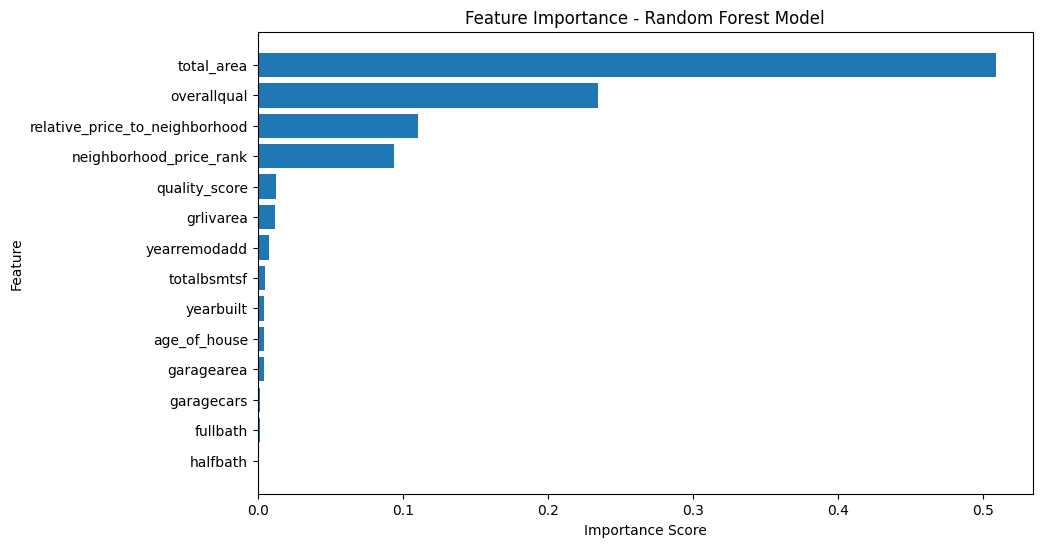

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance['feature'],
    feature_importance['importance']
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest Model")
plt.gca().invert_yaxis()
plt.show()


**"FirstUseCase.ipynb "** من

In [ ]:
def dynamic_price(base_price, demand_index):
    # base_price : السعر الأساسي (مثلاً السعر اللي الموديل طلعه)
    # demand_index : مؤشر الطلب
    # لو أكبر من 1 يبقى الطلب عالي
    # لو أقل من 1 يبقى الطلب ضعيف

    if demand_index > 1.2:
        # لو الطلب عالي قوي (أكتر من 120%)
        # نزود السعر 10% عشان نستغل زيادة الطلب
        return base_price * 1.1

    elif demand_index < 0.8:
        # لو الطلب ضعيف (أقل من 80%)
        # نقلل السعر 10% عشان نشجع الشراء
        return base_price * 0.9

    # لو الطلب متوسط (لا عالي ولا واطي)
    # نخلي السعر زي ما هو
    return base_price


In [ ]:
dynamic_price(100000, 1.3)  # الناتج = 110000
dynamic_price(100000, 0.7)  # الناتج = 90000
dynamic_price(100000, 1.0)  # الناتج = 100000


100000

**Investment Scoring Algorithm**


In [ ]:


def calculate_investment_score(row, model, feature_cols):


    predicted_price = model.predict(
        row[feature_cols].values.reshape(1, -1)
    )[0]

    neighborhood_avg = row['avg_price_neighborhood']

    quality_norm = row['overallqual'] / 10

    age_norm = 1 - (row['age_of_house'] / df['age_of_house'].max())

    roi_ratio = predicted_price / neighborhood_avg

    investment_score = (
        0.4 * roi_ratio +
        0.3 * quality_norm +
        0.3 * age_norm
    )

    return round(investment_score * 100, 2)


In [ ]:
# حساب Investment Score لكل العقارات
df['investment_score'] = df.apply(
    lambda row: calculate_investment_score(
        row, rf, feature_cols
    ),
    axis=1
)

df[['saleprice', 'avg_price_neighborhood', 'investment_score']].head()


,saleprice,avg_price_neighborhood,investment_score
0,208500.0,197965.773333,91.55
1,181500.0,238772.727273,70.58
2,223500.0,197965.773333,94.04
3,140000.0,210624.725490,58.21
4,250000.0,335295.317073,82.00



80 – 100	Excellent investment

60 – 79	Good investment

40 – 59	Moderate

< 40	High risk

**ClassificationUseCase** من








In [ ]:
import mlflow

mlflow.end_run()  # بتنهي الـ run الحالي


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gbr.fit(X_train, y_train)

pred_gbr = gbr.predict(X_test)

metrics_gbr = evaluate(y_test, pred_gbr)

print('Gradient Boosting metrics:')
for k, v in metrics_gbr.items():
    print(f'  {k}: {v:.4f}')

with mlflow.start_run(run_name="Gradient_Boosting"):
    mae, rmse, r2 = metrics_gbr['MAE'], metrics_gbr['RMSE'], metrics_gbr['R2']

    mlflow.log_param("model_name", "GradientBoosting")
    mlflow.log_param("n_estimators", gbr.n_estimators)
    mlflow.log_param("max_depth", gbr.max_depth)
    mlflow.log_param("learning_rate", gbr.learning_rate)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)

    signature = infer_signature(X_train, gbr.predict(X_train))

    mlflow.sklearn.log_model(
        gbr,
        artifact_path="model",
        signature=signature,
        registered_model_name="Property_Price_Model"
    )

print(" Gradient Boosting Regressor trained and logged to MLflow")


Gradient Boosting metrics:
  MAE: 5429.6397
  RMSE: 10168.8235
  R2: 0.9865


2025/12/20 18:58:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Gradient Boosting Regressor trained and logged to MLflow!


Successfully registered model 'Property_Price_Model'.
Created version '1' of model 'Property_Price_Model'.


In [ ]:
def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2
with mlflow.start_run(run_name="Linear_Regression"):

    mae, rmse, r2 = evaluate_metrics(y_test, pred_lr)

    mlflow.log_param("model_name", "LinearRegression")
    mlflow.log_param("num_features", X_train.shape[1])

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)

    signature = infer_signature(X_train, lr.predict(X_train))

    mlflow.sklearn.log_model(
        lr,
        artifact_path="model",
        signature=signature,
        registered_model_name="Property_Price_Model"
    )
with mlflow.start_run(run_name="Random_Forest"):

    mae, rmse, r2 = evaluate_metrics(y_test, pred_rf)

    mlflow.log_param("model_name", "RandomForest")
    mlflow.log_param("n_estimators", rf.n_estimators)
    mlflow.log_param("max_depth", rf.max_depth)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)

    signature = infer_signature(X_train, rf.predict(X_train))

    mlflow.sklearn.log_model(
        rf,
        artifact_path="model",
        signature=signature,
        registered_model_name="Property_Price_Model"
    )


2025/12/20 18:58:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'Property_Price_Model' already exists. Creating a new version of this model...
Created version '2' of model 'Property_Price_Model'.
2025/12/20 18:58:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'Property_Price_Model' already exists. Creating a new version of this model...
Created version '3' of model 'Property_Price_Model'.


In [ ]:
from mlflow.tracking import MlflowClient

joblib.dump(rf, "best_model.pkl")
joblib.dump(feature_cols, "features.pkl")

mlflow.log_artifact("best_model.pkl")
mlflow.log_artifact("features.pkl")
client = MlflowClient()

latest_versions = client.get_latest_versions(
    "Property_Price_Model",
    stages=["None"]
)

best_version = latest_versions[-1].version

client.transition_model_version_stage(
    name="Property_Price_Model",
    version=best_version,
    stage="Production"
)

print(f" Model version {best_version} promoted to Production")


 Model version 3 promoted to Production


أنا كان عندي موديلات بتتدرّب وتطلع أسعار عقارات، بس الشغل ده ماكانش متسجل ولا متقارن.
دخلت MLflow عشان أنظم كل التجارب.
عملت:
سجلت كل تجربة تدريب كمحاولة مستقلة (Run)
خزّنت إعدادات كل موديل ونتايجه (MAE, RMSE, R²)
قارنت بين أكتر من موديل جوه MLflow بسهولة
بعد كده:
سجّلت الموديلات في Model Registry
كل موديل أخد Version مختلف
اخترت أحسن Version وعيّنته Production
كمان:
خزّنت الموديل والـ features كـ Artifacts
وربطت الموديل بـ Use Case حقيقي (Dynamic Pricing)

In [ ]:
#check for engineered features

# df_features = pd.read_csv("property_with_location_features.csv")

# display(df_features.head())

# print(df_features.isnull().sum())

# print(df_features.describe())


In [ ]:
# df_merged = pd.read_csv("clean_merged_property_data.csv")

# display(df_merged.head())
# print(df_merged.isnull().sum())

# print(df_merged[['id','saleprice','grlivarea','yrsold','yearbuilt']].head())


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# ===============================
# Page Configuration
# ===============================
st.set_page_config(
    page_title="Property Price Prediction Dashboard",
    page_icon="🏠",
    layout="wide"
)

# ===============================
# Load Data & Model
# ===============================
@st.cache_data
def load_data():
    try:
        df = pd.read_csv("property_with_location_features.csv")
        return df
    except Exception as e:
        st.error(f"Failed to load data: {e}")
        return None


@st.cache_resource
def load_model():
    try:
        model = joblib.load("best_model.pkl")
        features = joblib.load("features.pkl")
        return model, features
    except Exception as e:
        st.error(f"Failed to load model: {e}")
        return None, None


df = load_data()
model, feature_cols = load_model()

# ===============================
# Sidebar Navigation
# ===============================
st.sidebar.title("Navigation")
page = st.sidebar.selectbox(
    "Select Page",
    [
        "About Project",
        "Explore Data",
        "Price Prediction",
        "Investment Analysis",
        "Model Performance"
    ]
)

# ===============================
# About Page
# ===============================
if page == "About Project":
    st.title("🏠 Property Price Prediction System")

    st.markdown("""
    ### Project Overview
    This project predicts **house prices** using machine learning models
    trained on historical real estate data.

    ### Key Components
    - Linear Regression
    - Random Forest Regressor
    - Gradient Boosting Regressor
    - Feature Engineering
    - MLflow for experiment tracking
    - Investment Scoring logic

    ### Business Use Cases
    - Property price estimation
    - Investment decision support
    - Neighborhood price comparison
    - Dynamic pricing strategies
    """)

# ===============================
# Explore Data
# ===============================
elif page == "Explore Data":
    st.title("📊 Property Data Exploration")

    if df is None:
        st.stop()

    col1, col2, col3 = st.columns(3)

    with col1:
        st.metric("Total Properties", len(df))
    with col2:
        st.metric("Average Price", f"${df['saleprice'].mean():,.0f}")
    with col3:
        st.metric("Max Price", f"${df['saleprice'].max():,.0f}")

    st.subheader("Price Distribution")
    fig, ax = plt.subplots()
    ax.hist(df['saleprice'], bins=40)
    ax.set_xlabel("Sale Price")
    ax.set_ylabel("Count")
    st.pyplot(fig)

    if st.checkbox("Show Raw Data"):
        st.dataframe(df.head(100))

# ===============================
# Price Prediction
# ===============================
elif page == "Price Prediction":
    st.title("🔮 Predict Property Price")

    if df is None or model is None:
        st.stop()

    st.subheader("Enter Property Features")

    user_input = {}
    for col in feature_cols:
        user_input[col] = st.number_input(
            col,
            value=float(df[col].median())
        )

    input_df = pd.DataFrame([user_input])

    if st.button("Predict Price"):
        predicted_price = model.predict(input_df)[0]
        st.success(f"Estimated Property Price: ${predicted_price:,.0f}")

# ===============================
# Investment Analysis
# ===============================
elif page == "Investment Analysis":
    st.title("📈 Investment Scoring")

    if df is None or model is None:
        st.stop()

    st.markdown("""
    **Investment Score Interpretation**
    - 80–100 → Excellent Investment
    - 60–79 → Good Investment
    - 40–59 → Moderate
    - < 40 → High Risk
    """)

    sample = df.sample(1).iloc[0]

    predicted_price = model.predict(
        sample[feature_cols].values.reshape(1, -1)
    )[0]

    roi_ratio = predicted_price / sample['avg_price_neighborhood']
    quality_norm = sample['overallqual'] / 10
    age_norm = 1 - (sample['age_of_house'] / df['age_of_house'].max())

    investment_score = (
        0.4 * roi_ratio +
        0.3 * quality_norm +
        0.3 * age_norm
    ) * 100

    st.metric("Predicted Price", f"${predicted_price:,.0f}")
    st.metric("Neighborhood Avg Price", f"${sample['avg_price_neighborhood']:,.0f}")
    st.metric("Investment Score", f"{investment_score:.2f}")

# ===============================
# Model Performance
# ===============================
elif page == "Model Performance":
    st.title("📉 Model Performance Overview")

    st.markdown("""
    Models were trained and evaluated using:
    - MAE
    - RMSE
    - R² Score

    All experiments were tracked using **MLflow**.
    Best-performing model was promoted to **Production**.
    """)

    st.info(
        "For detailed experiment comparison, "
        "open the MLflow UI using: mlflow ui"
    )

# ===============================
# Footer
# ===============================
st.sidebar.markdown("---")
st.sidebar.markdown("""
**How to Run**
1. Train models & save artifacts
2. Install Streamlit
3. `streamlit run property_price_streamlit_app.py`
""")


ModuleNotFoundError: No module named 'streamlit'